<a href="https://colab.research.google.com/github/beyzoskaya/machineLearning_CS454/blob/main/homeworks/convolutionalAutoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [667]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import random_split


In [668]:
from torchvision.datasets import FashionMNIST

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, resize_transform=None, target_transform=None):
        self.data = data
        self.resize_transform = resize_transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]

        if self.target_transform:
            original_image = self.target_transform(image)

        if self.resize_transform:
            resized_image = self.resize_transform(image)

        return resized_image, original_image,label


In [669]:
resize_transform = transforms.Compose([
    transforms.Resize((7,7)),
    transforms.ToTensor(),
])

target_transform_train = transforms.Compose([
  transforms.ToTensor(),
])

target_transform_test = transforms.Compose([
    transforms.ToTensor(),
])


In [670]:
train_dataset_original = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset_original  = torchvision.datasets.FashionMNIST(root='data', train=False, download=True)


In [671]:
train_dataset = CustomDataset(train_dataset_original,resize_transform=resize_transform, target_transform=target_transform_train)
test_dataset = CustomDataset(test_dataset_original, resize_transform=resize_transform, target_transform=target_transform_test)


In [672]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [673]:
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])


In [674]:
len(validation_dataset)

12000

In [675]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Resized Images:


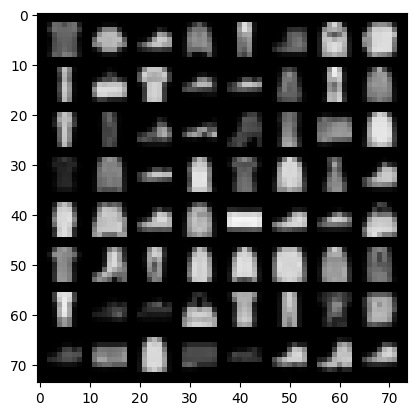

Original Images:


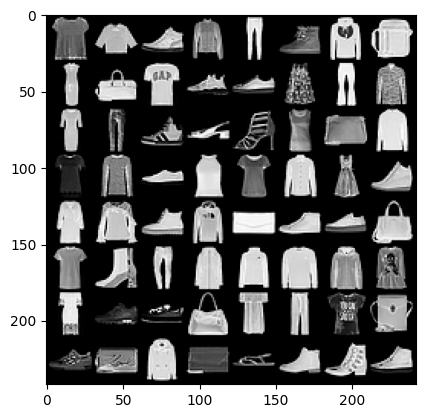

In [676]:
import matplotlib.pyplot as plt

def imshow(img):
    # if using normalization in transforms, you may need to normalize
    # img = img / 2 + 0.5  # unnormalize if you used normalization in your transforms
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
resized_images, original_images, labels = next(dataiter)

# Show images
print("Resized Images:")
imshow(torchvision.utils.make_grid(resized_images))
print("Original Images:")
imshow(torchvision.utils.make_grid(original_images))


Resized Images:


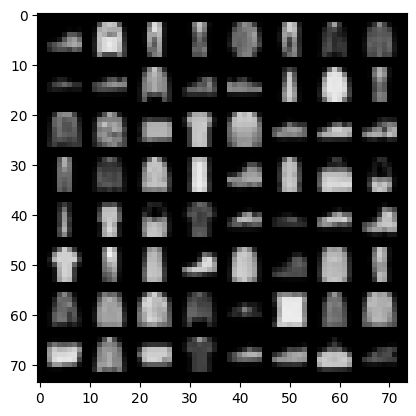

Original Images:


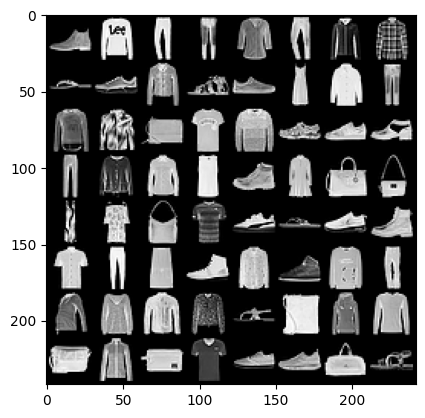

In [677]:
def imshow_test(img):
    # if using normalization in transforms, you may need to normalize
    # img = img / 2 + 0.5  # unnormalize if you used normalization in your transforms
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(test_loader)
resized_images, original_images, labels = next(dataiter)

# Show images
print("Resized Images:")
imshow_test(torchvision.utils.make_grid(resized_images))
print("Original Images:")
imshow_test(torchvision.utils.make_grid(original_images))


Resized Images:


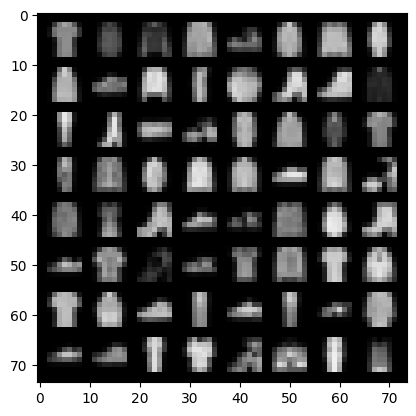

Original Images:


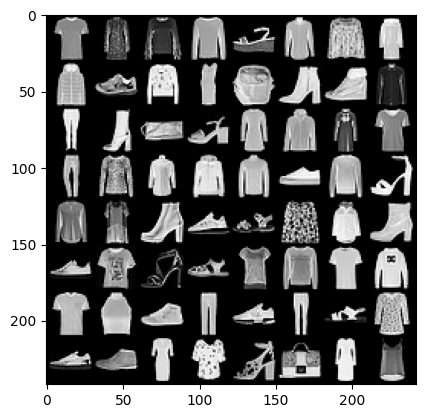

In [678]:
def imshow_val(img):
    # if using normalization in transforms, you may need to normalize
    # img = img / 2 + 0.5  # unnormalize if you used normalization in your transforms
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(validation_loader)
resized_images, original_images, labels = next(dataiter)

# Show images
print("Resized Images:")
imshow_val(torchvision.utils.make_grid(resized_images))
print("Original Images:")
imshow_val(torchvision.utils.make_grid(original_images))


In [679]:
len(train_loader), len(validation_loader), len(test_loader)

(750, 188, 157)

In [680]:
for batch in train_loader:
    resized_images, original_images, labels = batch

    # Print the shape of the resized images
    print("Shape of resized images:", resized_images.shape)

    # Print the shape of the original images
    print("Shape of original images:", original_images.shape)

    # Print the labels
    print("Labels:", labels)

    # Break the loop after the first batch
    break


Shape of resized images: torch.Size([64, 1, 7, 7])
Shape of original images: torch.Size([64, 1, 28, 28])
Labels: tensor([7, 7, 9, 6, 4, 7, 8, 0, 8, 7, 8, 6, 4, 1, 9, 2, 8, 9, 3, 7, 2, 9, 0, 0,
        5, 5, 9, 0, 7, 3, 6, 6, 8, 4, 2, 2, 7, 4, 8, 1, 2, 9, 3, 3, 0, 3, 6, 0,
        8, 8, 2, 3, 2, 4, 4, 7, 5, 8, 0, 1, 5, 3, 9, 7])


In [681]:
label_classes = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

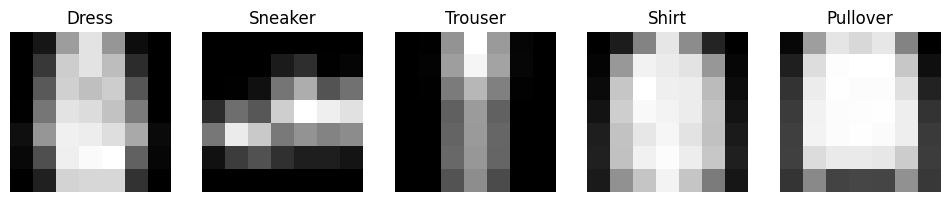

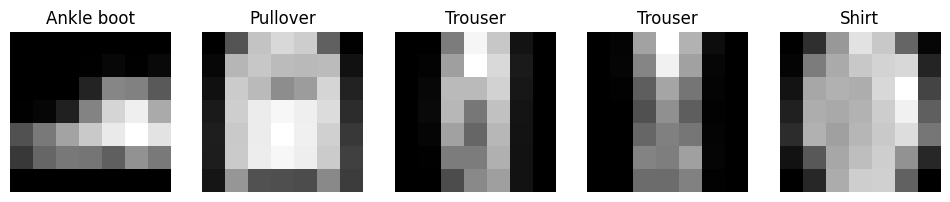

In [682]:
import matplotlib.pyplot as plt

def show_images(dataloader, num_images=5):

    for resized_images, original_images, labels in dataloader:
        resized_images = resized_images[:num_images]
        labels = labels[:num_images]

        plt.figure(figsize=(12, 6))

        for i, (image, label) in enumerate(zip(resized_images, labels)):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image.permute(1, 2, 0).numpy().squeeze(), cmap='gray')
            plt.title(f"{label_classes[label.item()]}")
            plt.axis('off')

        plt.show()
        break

show_images(train_loader)
show_images(test_loader)

In [683]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=1, padding=0),  # 7x7 -> 5x5
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten(start_dim=1)
        # Adjust the number of input features to match the output of the last conv layer
        self.encoder_lin = nn.Sequential(
            nn.Linear(16 * 5 * 5, encoded_space_dim),  # 16 --> last conv layer, 5--> 5x5 last conv dimension
            nn.ReLU(True)
        )

    def forward(self, x):
        #print(f"Shape initially inside encoder: {x.shape}")
        x = self.encoder_cnn(x)
        #print(f"Shape after encoder cnn: {x.shape}")
        x = self.flatten(x)
        #print(f"Shape after flatten: {x.shape}")
        x = self.encoder_lin(x)
        #print(f"Shape after encoder linear: {x.shape}")
        return x


In [684]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Linear(encoded_space_dim, 16 * 5 * 5)
        self.unflatten = nn.Unflatten(1, (16, 5, 5))

        # [5x5] to [7x7]
        self.upconv1 =nn.Sequential(
          nn.ConvTranspose2d(16,16, kernel_size=3, stride=1, padding=0),
          nn.ReLU(True)
        )
        self.upconv2 = nn.Sequential(
          nn.ConvTranspose2d(16,8,kernel_size=3, stride=1, padding=1),
          nn.ReLU(True)
        )
        self.upconv3 = nn.Sequential(
          nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True)
        )
        self.final_conv = nn.Sequential(
          nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True)
        )

    def forward(self, x):
        #print(f"Shape initially inside decoder: {x.shape}")
        x = self.decoder_lin(x)
        #print(f"Shape after decoder linear: {x.shape}")
        x = self.unflatten(x)
        #print(f"Shape after unflatten: {x.shape}")

        x = self.upconv1(x)
        #print(f"Shape after first convolutional: {x.shape}")
        x = self.upconv2(x)
        #print(f"Shape after second conv: {x.shape}")
        x = self.upconv3(x)
        #print(f"Shape after third conv: {x.shape}")
        x = self.final_conv(x)
        #print(f"Shape after final conv: {x.shape}")
        #x = torch.sigmoid(x)

        #print(f"Shape after sigmoid: {x.shape}")
        return x


In [685]:
class EncoderWithOneConv(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        # self.encoder_cnn = nn.Sequential(
        #     nn.Conv2d(1, 8, 3, stride=1, padding=1),  # 7x7 -> 7x7
        #     nn.ReLU(True),
        #     nn.Conv2d(8, 16, 3, stride=1, padding=0),  # 7x7 -> 5x5
        #     nn.ReLU(True),
        #     nn.Conv2d(16, 16, 3, stride=1, padding=1),  # New Convolutional Layer
        #     nn.ReLU(True),
        # )

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.ReLU(True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=1, padding=0),
            nn.ReLU(True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(True),
        )

        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(16 * 5 * 5, encoded_space_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        print(f"Shape initially inside decoder: {x.shape}")
        x = self.conv1(x)
        print(f"Shape after conv1: {x.shape}")
        x = self.conv2(x)
        print(f"Shape after conv2: {x.shape}")
        x = self.conv3(x)
        print(f"Shape after conv3: {x.shape}")
        x = self.flatten(x)
        print("Shape after flatten: {x.shape}")
        x = self.encoder_lin(x)
        print(f"Shape after linear: {x.shap}")
        return x


class DecoderForOneConv(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Linear(encoded_space_dim, 16 * 5 * 5)
        self.unflatten = nn.Unflatten(1, (16, 5, 5))

        # [5x5] to [7x7]
        self.upconv1 =nn.Sequential(
          nn.ConvTranspose2d(16,16, kernel_size=3, stride=1, padding=0),
          nn.ReLU(True)
        )
        self.upconv2 = nn.Sequential(
          nn.ConvTranspose2d(16,8,kernel_size=3, stride=1, padding=1),
          nn.ReLU(True)
        )
        self.upconv3 = nn.Sequential(
          nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True)
        )
        self.final_conv = nn.Sequential(
          nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True)
        )

    def forward(self, x):
        #print(f"Shape initially inside decoder: {x.shape}")
        x = self.decoder_lin(x)
        #print(f"Shape after decoder linear: {x.shape}")
        x = self.unflatten(x)
        #print(f"Shape after unflatten: {x.shape}")

        x = self.upconv1(x)
        #print(f"Shape after first convolutional: {x.shape}")
        x = self.upconv2(x)
        #print(f"Shape after second conv: {x.shape}")
        x = self.upconv3(x)
        #print(f"Shape after third conv: {x.shape}")
        x = self.final_conv(x)
        #print(f"Shape after final conv: {x.shape}")
        #x = torch.sigmoid(x)

        #print(f"Shape after sigmoid: {x.shape}")
        return x


In [686]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.0001

### Set the random seed for reproducible results

### Initialize the two networks
d = 16

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr)


In [687]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


Selected device: cpu


Decoder(
  (decoder_lin): Linear(in_features=16, out_features=400, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 5, 5))
  (upconv1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (upconv2): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (upconv3): Sequential(
    (0): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (final_conv): Sequential(
    (0): ConvTranspose2d(4, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
)

In [688]:
encoder

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=400, out_features=16, bias=True)
    (1): ReLU(inplace=True)
  )
)

In [689]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []

    # Iterate the dataloader
    for resized_image, original_image, _ in dataloader:
        # Move tensor to the proper device
        resized_image = resized_image.to(device)
        #print(f"Shape for resized image: {resized_image.shape}")
        original_image = original_image.to(device)
        #print(f"Shape for original image: {original_image.shape}")

        # Encode data
        encoded_data = encoder(resized_image)

        # Decode data
        decoded_data = decoder(encoded_data)

        # Evaluate loss
        loss = loss_fn(decoded_data, original_image)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


In [690]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad():  # No need to track the gradients
        # Define the lists to store the outputs and labels for each batch
        conc_out = []
        conc_original = []

        # Iterate the dataloader
        for resized_image, original_image, _ in dataloader:
            # Move tensor to the proper device
            resized_image = resized_image.to(device)
            #print(f"Shape for resized image: {resized_image.shape}")
            original_image = original_image.to(device)
            #print(f"Shape for original image: {original_image.shape}")

            # Encode and Decode data
            encoded_data = encoder(resized_image)
            decoded_data = decoder(encoded_data)

            # Append the decoded data and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_original.append(original_image.cpu())

        # Concatenate all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_original = torch.cat(conc_original)

        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_original)

    return val_loss.item()  # Use .item() to get the scalar value of the loss tensor


In [691]:
test_dataset[0][0].shape

torch.Size([1, 7, 7])

In [692]:
train_dataset[0][0].shape

torch.Size([1, 7, 7])

In [693]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [694]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)



	 partial train loss (single batch): 0.140970
	 partial train loss (single batch): 0.139766
	 partial train loss (single batch): 0.148149
	 partial train loss (single batch): 0.140879
	 partial train loss (single batch): 0.143845
	 partial train loss (single batch): 0.123332
	 partial train loss (single batch): 0.150806
	 partial train loss (single batch): 0.147518
	 partial train loss (single batch): 0.128580
	 partial train loss (single batch): 0.140153
	 partial train loss (single batch): 0.145050
	 partial train loss (single batch): 0.160460
	 partial train loss (single batch): 0.141517
	 partial train loss (single batch): 0.164662
	 partial train loss (single batch): 0.145732
	 partial train loss (single batch): 0.131781
	 partial train loss (single batch): 0.132766
	 partial train loss (single batch): 0.139001
	 partial train loss (single batch): 0.142234
	 partial train loss (single batch): 0.129576
	 partial train loss (single batch): 0.167345
	 partial train loss (single batch

AttributeError: ignored

<Figure size 1600x450 with 0 Axes>